# PTA Supermassive Black Holes Single Source to GWB

Here we run through a simple example of making a gravitational wave skymap that calculates the gravitational waves strain and the time of arrival perturbation of pulsar pulses. 

In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
%config InlineBackend.figure_format = 'retina'

In [2]:
from gw_sky import gwsky

In [3]:
pop = gwsky.smbbh_pop()

In [4]:
L = 20
costh = np.random.uniform(-1,1,size= L-3)
th = np.arccos(costh)
ph = np.random.uniform(0,2*np.pi,size= L-3)
th = np.append([np.pi/2,np.pi/4,np.pi/2+0.1],th)
ph = np.append([0,3*np.pi/2,np.pi-0.1],ph)
gw = []
for ii in range(L):
    freq = pop['GWFreq'][ii]
    h = -pop['Strain'][ii] # Strains are saved as negative values for some reason...
    gw.append(gwsky.SMBBH(freq,h,th[ii],ph[ii]))

In [5]:
t = np.linspace(0,12.9*365.25*24*3600,200)

In [6]:
NSIDE = 32
NPIX = hp.nside2npix(NSIDE)
IPIX = np.arange(NPIX)
theta, phi = hp.pix2ang(nside=NSIDE,ipix=IPIX)

In [7]:
sky = gwsky.GWSky(gw,theta,phi)

In [8]:
#One can either 
# str = sky.strain(t)
res = sky.residuals(t)

In [9]:
res.shape

(12288, 20, 200)

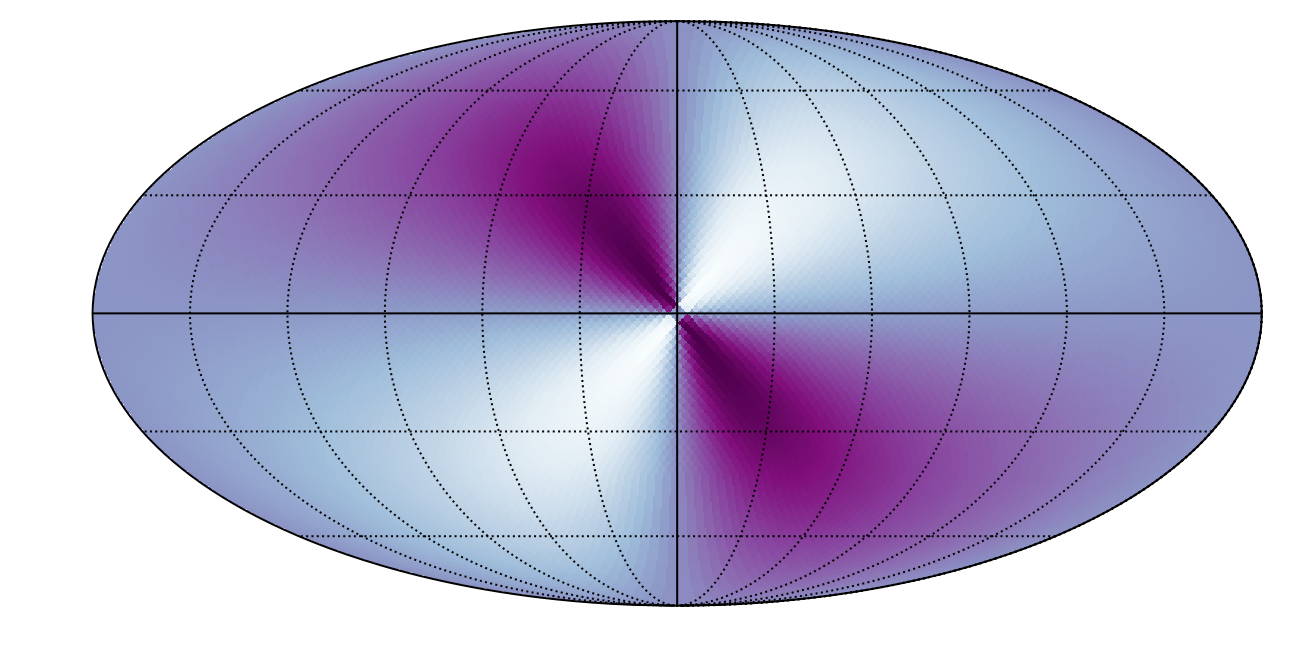

In [10]:
hp.mollview(res[:,0,0], cbar=False,title='',cmap='BuPu')
hp.graticule(verbose=False)

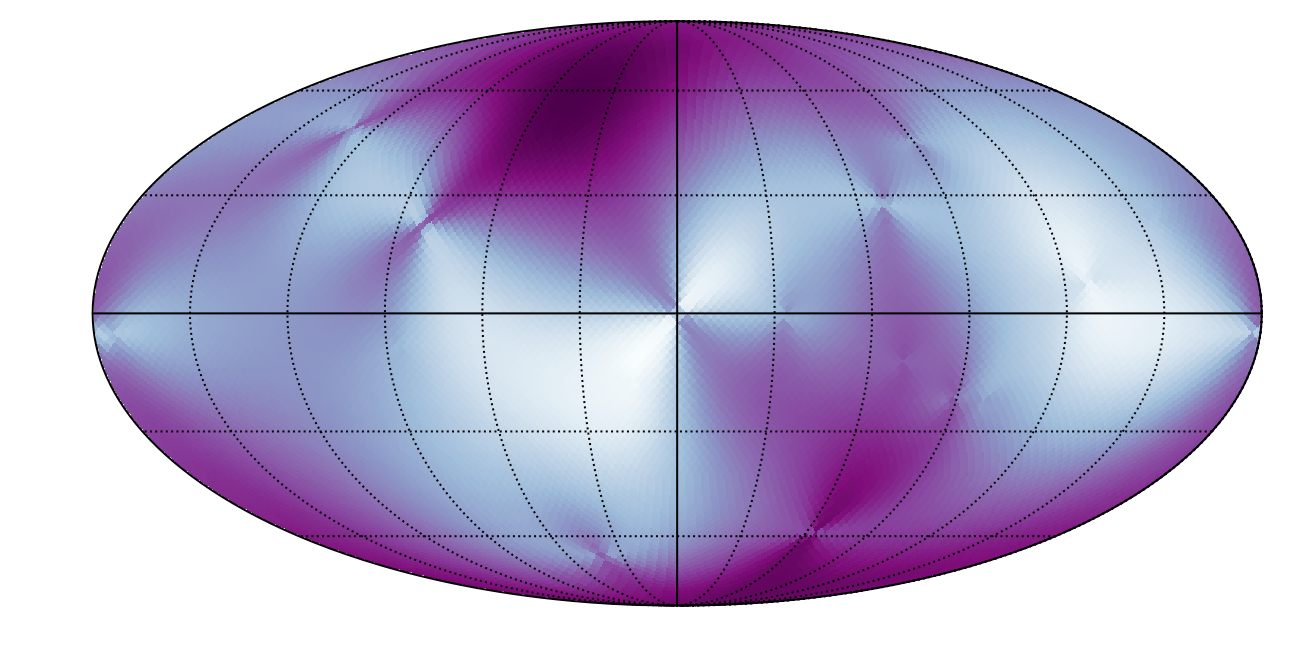

In [11]:
hp.mollview(np.sum(res[:,:,0],axis=1), cbar=False,title='',cmap='BuPu')
hp.graticule(verbose=False)

In [12]:
yr_in_sec = 365.25*24*3600

In [13]:
def maxmin(array):
    """Return the max an min of an array."""
    return array.max(), array.min()

def gw_sum(array, n='all'):
    '''
    Convenience function to return either a single source,
    sum of a list of sources indicated by index or all summed sources.
    '''
    if n=='all':
        return np.sum(array,axis=1)
    elif isinstance(n,list):
        return np.sum(array[:,n,:],axis=1)
    elif isinstance(n,int):
        return array[:,n,:]

In [14]:
def plot_gw(residuals,
            psrs=[0,1,[0,1],'all'],
            Nt=1,
            action='show',
            name='./gwb_resids/gwb_full'):
    ii = 0
    for p in psrs:
        res = gw_sum(residuals,n=p)
        Max, Min = maxmin(res)
        idx1 = 9000
        idx2 = 6500
        idx3 = 2500
        ang1=hp.pix2ang(NSIDE,idx1)
        ang2=hp.pix2ang(NSIDE,idx2)
        ang3=hp.pix2ang(NSIDE,idx3)
        
        if p=='all':
            space = 0.01*2*(res[idx1,:].max()+res[idx2,:].max()+res[idx3,:].max())
        else:
            space = 0.1*2*(res[idx1,:].max()+res[idx2,:].max()+res[idx3,:].max())
        shifts = [np.abs(res[idx1,:].min())+ res[idx2,:].max() + space,
                  0,
                  res[idx2,:].min() - res[idx3,:].max() - space]

        for n in range(Nt):
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=[9,9],
                                           gridspec_kw={'height_ratios': [2, 1]})
            # Plot the sky map
            plt.sca(ax1)
            hp.mollview(res[:,n], cbar=False,title='',cmap='BuPu',min=Min,max=Max, hold=True)
            hp.graticule(verbose=False)
            
            # Plot the stars on the sky map
            hp.projscatter(ang1[0],ang1[1],s=22**2,marker='*',color='C0',edgecolors='k',zorder=3)
            hp.projscatter(ang2[0],ang2[1],s=22**2,marker='*',color='C1',edgecolors='k',zorder=3)
            hp.projscatter(ang3[0],ang3[1],s=22**2,marker='*',color='C3',edgecolors='k',zorder=3)
    
            # Plot the traces on the traceplot. Shift by the amount calculated above.
            ax2.plot(t/yr_in_sec,res[idx1,:]+shifts[0],color='C0', lw=2)
            ax2.plot(t/yr_in_sec,res[idx2,:]+shifts[1],color='C1', lw=2)
            ax2.plot(t/yr_in_sec,res[idx3,:]+shifts[2],color='C3', lw=2)
            
            
            # Plot the stars on the trace plot
            ax2.scatter(0,res[idx1,0]+shifts[0],s=22**2,marker='*',color='C0',edgecolors='k',zorder=3)
            ax2.scatter(0,res[idx2,0]+shifts[1],s=22**2,marker='*',color='C1',edgecolors='k',zorder=3)
            ax2.scatter(0,res[idx3,0]+shifts[2],s=22**2,marker='*',color='C3',edgecolors='k',zorder=3)
            
            # Plot the verticle line that shows the current time.
            ax2.axvline(t[n]/yr_in_sec, linewidth=0.7,color='k')
            ax2.set_yticks([])
            ax2.set_xlabel('Years',fontsize=12)
            ax2.set_ylabel(r'Gravitational Wave Strain',fontsize=12)
#             ax2.set_ylabel(r'Change in Arrival Time',fontsize=12)
            if isinstance(p,int):
                N = 1
            elif isinstance(p,list):
                N = len(p)
            elif p=='all':
                N = L
            ax2.set_title(f'Number of Gravitational Waves Sources: {N}')
            fig.text(x=0.64,y=0.12,s='Image Credit: Jeffrey S. Hazboun')
            box = ax2.get_position()

            box.y0 = box.y0 + 0.051
            box.y1 = box.y1 + 0.051
            ax2.set_position(box)
            
            if action=='save':
                plt.savefig(f'{name}_{ii}.png', dpi=171, bbox_inches='tight')
            elif action=='show':
                plt.show()
                
            ii+=1
            plt.close()

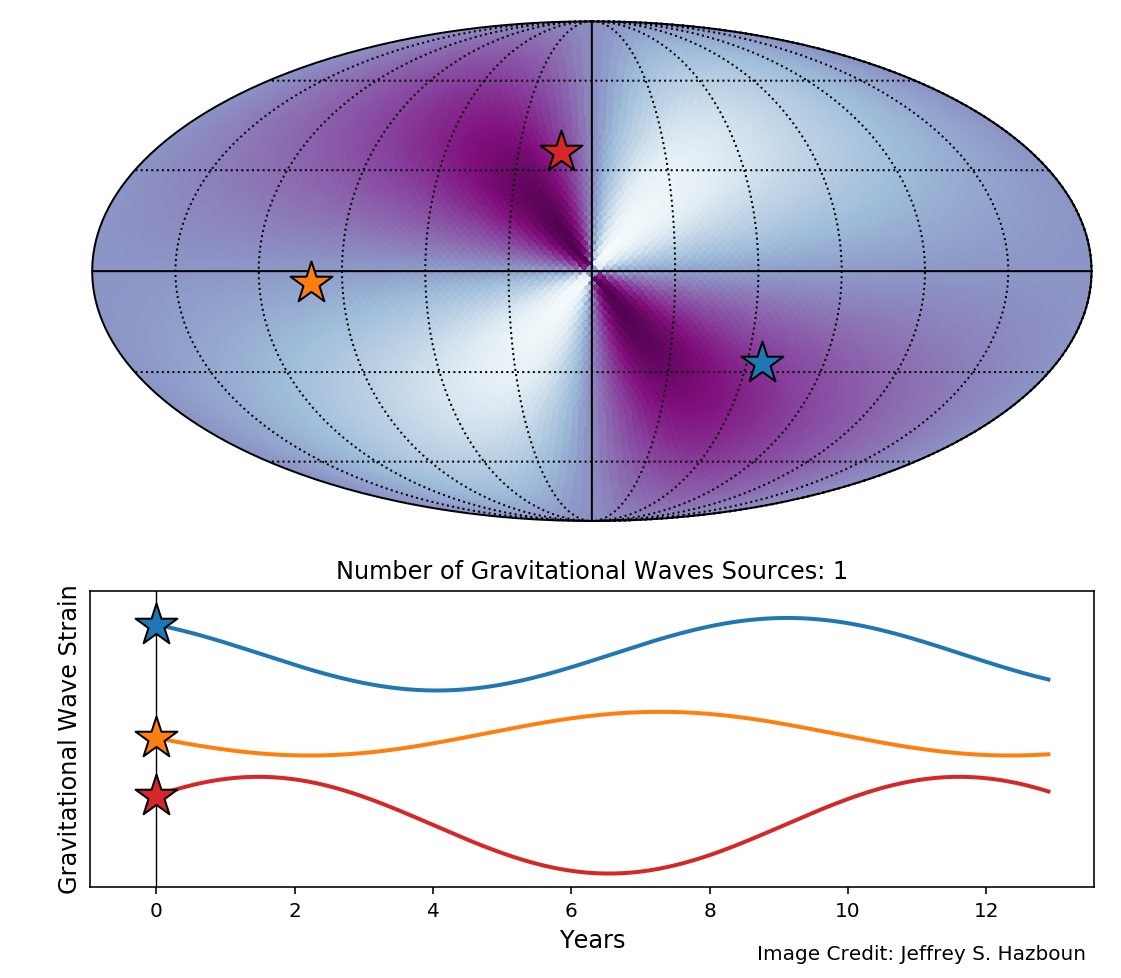

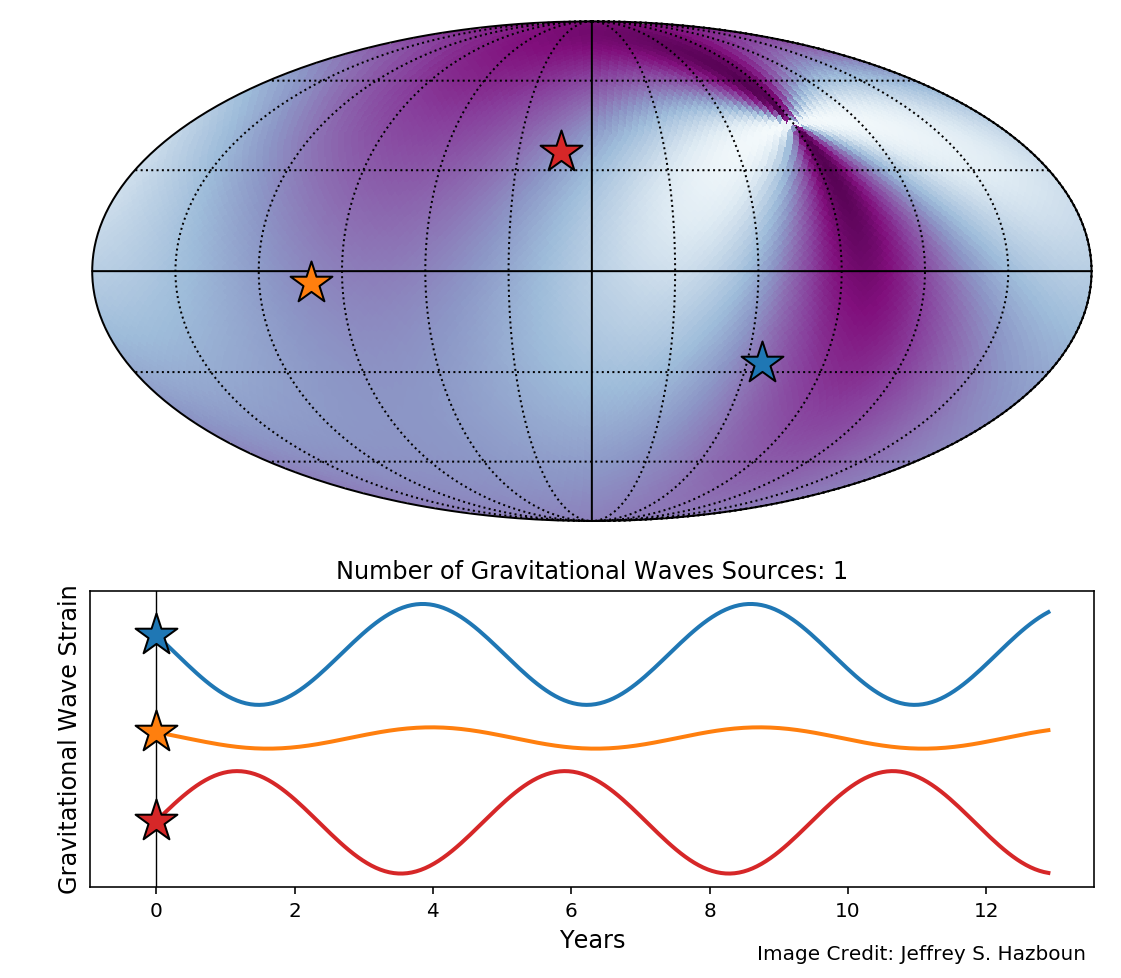

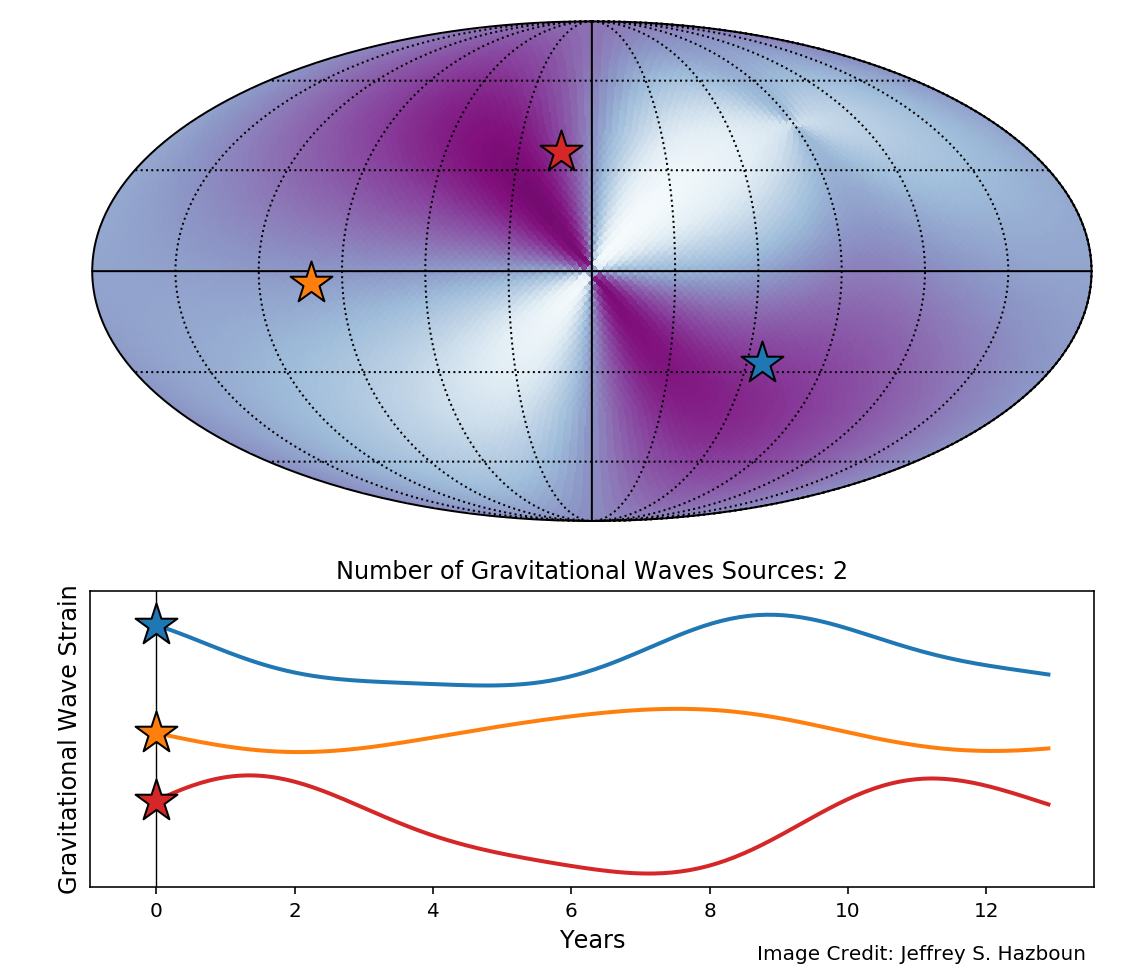

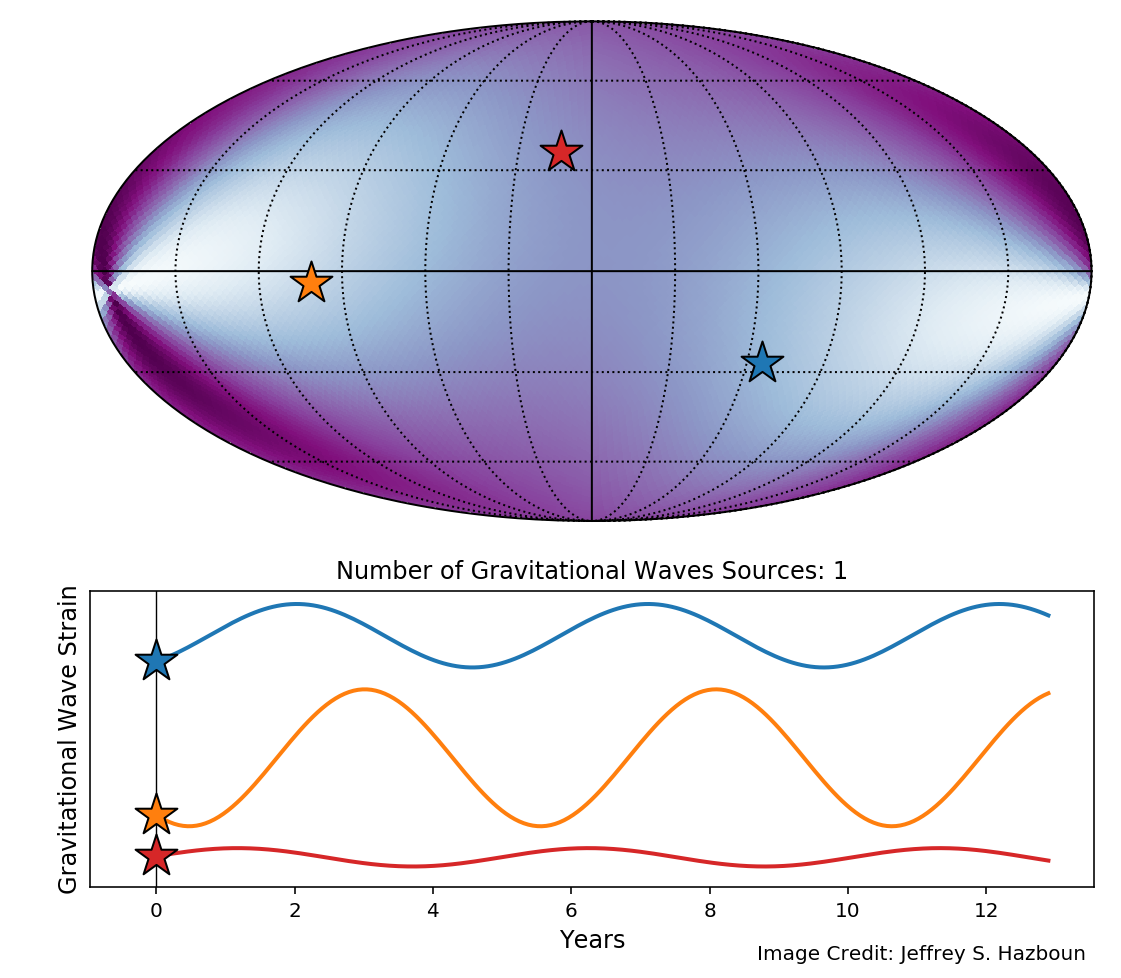

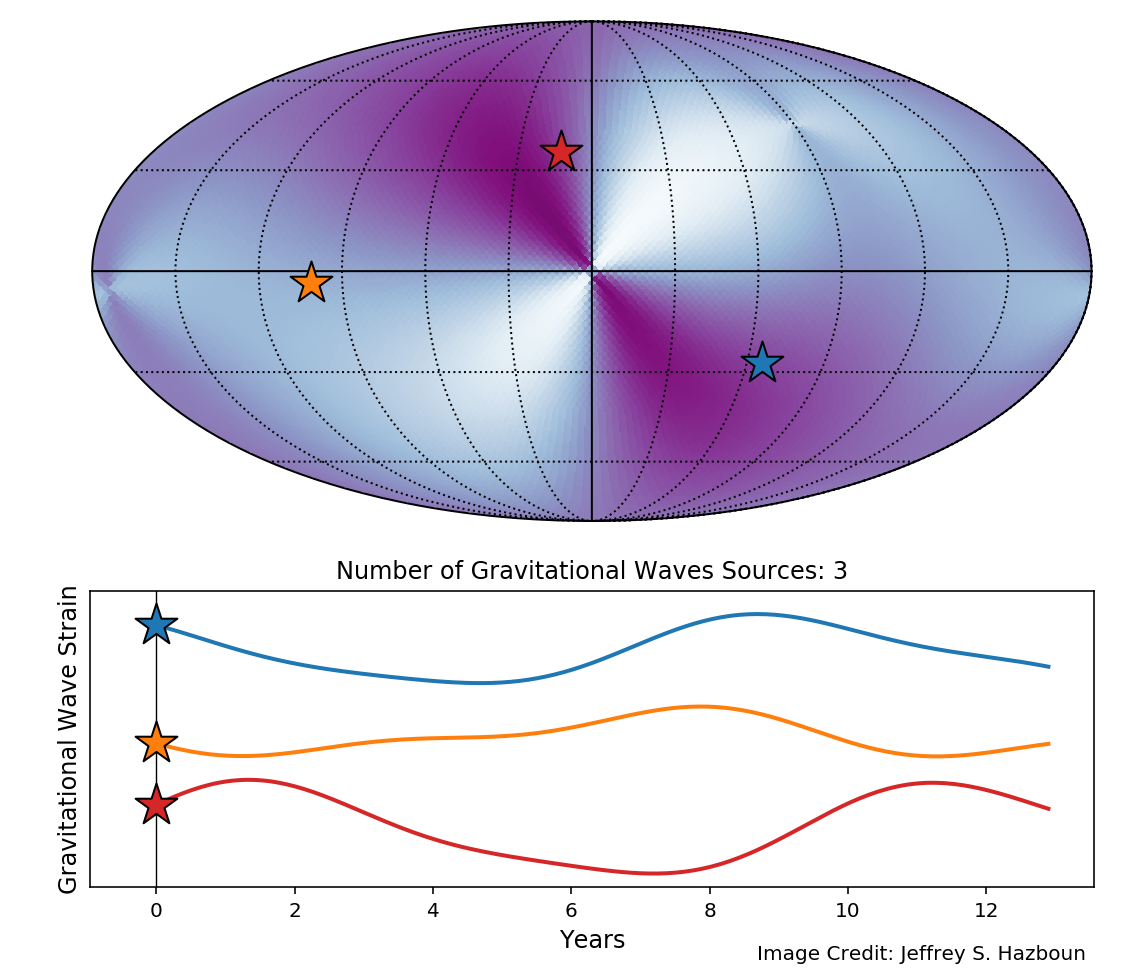

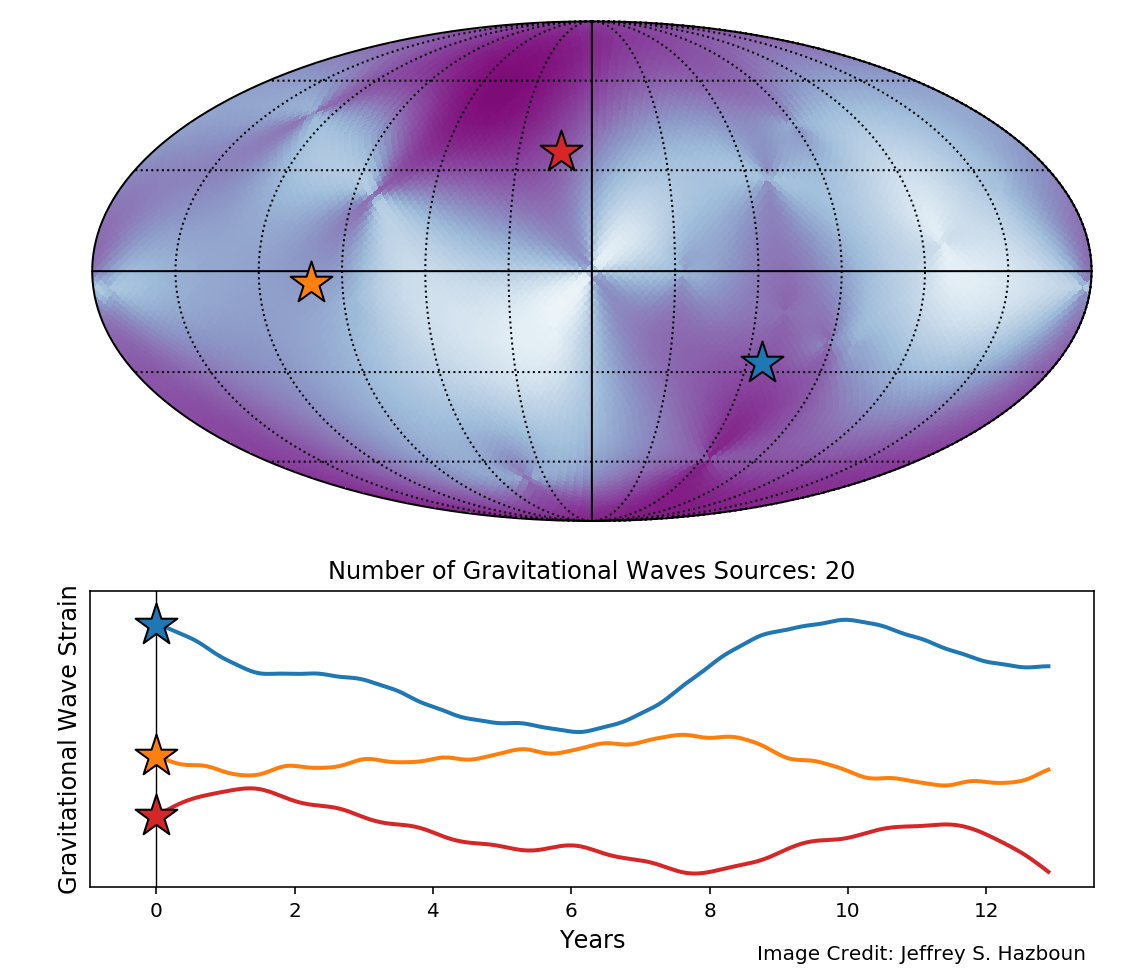

In [15]:
plot_gw(res, psrs=[0,1,[0,1],2,[0,1,2],'all'], Nt=1, action='show')#

In [16]:
# plot_gw(res,psrs=[0,1,[0,1],2,[0,1,2],'all'], Nt=300, action='save',name='./gwb_resids/gwb_full')#

In [17]:
#! ffmpeg -r 18 -f image2 -s 1920x1080 -i one_source_%d.png -vcodec libx264 -crf 15  -pix_fmt yuv420p one_source.mp4

In [18]:
#! ffmpeg -i gwb_full_%d.png -vf palettegen palette.png

In [19]:
#! ffmpeg -y -i gwb_full_%d.png -i palette.png -filter_complex "fps=45,scale=1032:-1:flags=lanczos[x];[x][1:v]paletteuse" gwb_full.gif